In [31]:
import os
import re
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------
# Configuration
# -------------------------
IMAGE_SIZE = 50
NUM_TEST_SAMPLES = 80
NOISE_RATIO = 0.5           # 50% noisy, 50% clean
NOISE_MAX_VALUE = 200       # < 255 (signal invariant)
PIXEL_TOLERANCE = 1
OUTPUT_DIR = "images"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------
# CLEAR OLD TEST IMAGES
# -------------------------
for f in os.listdir(OUTPUT_DIR):
    if f.endswith(".png"):
        os.remove(os.path.join(OUTPUT_DIR, f))

# -------------------------
# Test image generation
# -------------------------
def generate_single_image(noisy=False, noise_pixels=20):
    image = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)

    x = np.random.randint(0, IMAGE_SIZE)
    y = np.random.randint(0, IMAGE_SIZE)

    image[y, x] = 255  # signal pixel (always strongest)

    if noisy:
        for _ in range(noise_pixels):
            nx = np.random.randint(0, IMAGE_SIZE)
            ny = np.random.randint(0, IMAGE_SIZE)
            if image[ny, nx] == 0:
                image[ny, nx] = np.random.randint(1, NOISE_MAX_VALUE)

    return image, (x, y)

# -------------------------
# Generate & save RAW test images
# -------------------------
print("Generating test images...")

for i in range(NUM_TEST_SAMPLES):
    is_noisy = np.random.rand() < NOISE_RATIO
    img, (x, y) = generate_single_image(noisy=is_noisy)

    img_type = "noisy" if is_noisy else "clean"
    filename = f"sample_{i:02d}_{img_type}_raw_x{x}_y{y}.png"
    plt.imsave(os.path.join(OUTPUT_DIR, filename), img, cmap="gray")

print(f"{NUM_TEST_SAMPLES} RAW images saved to '{OUTPUT_DIR}/'")

# -------------------------
# Load model
# -------------------------
model = tf.keras.models.load_model("pixel_coordinate_regressor.keras")

# -------------------------
# Evaluation
# -------------------------
pixel_errors = []
correct = 0
total = 0

print("\nEvaluating images...\n")

for fname in sorted(os.listdir(OUTPUT_DIR)):
    if not fname.endswith(".png"):
        continue

    match = re.search(r"x(\d+)_y(\d+)", fname)
    if match is None:
        continue

    gt_x, gt_y = int(match.group(1)), int(match.group(2))

    path = os.path.join(OUTPUT_DIR, fname)
    image = Image.open(path).convert("L")
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image, dtype=np.uint8)

    # -------------------------
    # Signal-preserving cleaning
    # -------------------------
    cleaned = np.zeros_like(image)
    ys, xs = np.unravel_index(np.argmax(image), image.shape)
    cleaned[ys, xs] = 255

    input_tensor = cleaned.astype("float32") / 255.0
    input_tensor = input_tensor[np.newaxis, ..., np.newaxis]

    heatmap = model.predict(input_tensor, verbose=0)[0]
    hm = heatmap.squeeze()
    pred_y, pred_x = np.unravel_index(np.argmax(hm), hm.shape)

    error = np.sqrt((pred_x - gt_x) ** 2 + (pred_y - gt_y) ** 2)
    pixel_errors.append(error)

    is_correct = error <= PIXEL_TOLERANCE
    correct += int(is_correct)
    total += 1

    print(
        f"{fname} | "
        f"GT=({gt_x},{gt_y}) | "
        f"Pred=({pred_x},{pred_y}) | "
        f"Error={error:.2f} | "
        f"{'✅' if is_correct else '❌'}"
    )

# -------------------------
# Summary
# -------------------------
print("\n--- FINAL SUMMARY ---")
print(f"Total samples evaluated: {total}")
print(f"Accuracy (≤{PIXEL_TOLERANCE} px): {100 * correct / total:.2f}%")
print(f"Mean pixel error: {np.mean(pixel_errors):.2f}")
print(f"Median pixel error: {np.median(pixel_errors):.2f}")


Generating test images...
80 RAW images saved to 'images/'

Evaluating images...

sample_00_clean_raw_x39_y34.png | GT=(39,34) | Pred=(39,34) | Error=0.00 | ✅
sample_01_clean_raw_x6_y21.png | GT=(6,21) | Pred=(6,21) | Error=0.00 | ✅
sample_02_noisy_raw_x44_y22.png | GT=(44,22) | Pred=(44,22) | Error=0.00 | ✅
sample_03_noisy_raw_x8_y20.png | GT=(8,20) | Pred=(8,20) | Error=0.00 | ✅
sample_04_noisy_raw_x29_y3.png | GT=(29,3) | Pred=(29,3) | Error=0.00 | ✅
sample_05_clean_raw_x3_y22.png | GT=(3,22) | Pred=(3,22) | Error=0.00 | ✅
sample_06_noisy_raw_x11_y30.png | GT=(11,30) | Pred=(11,30) | Error=0.00 | ✅
sample_07_noisy_raw_x36_y0.png | GT=(36,0) | Pred=(36,0) | Error=0.00 | ✅
sample_08_noisy_raw_x3_y7.png | GT=(3,7) | Pred=(3,7) | Error=0.00 | ✅
sample_09_clean_raw_x38_y41.png | GT=(38,41) | Pred=(38,41) | Error=0.00 | ✅
sample_10_clean_raw_x40_y45.png | GT=(40,45) | Pred=(40,45) | Error=0.00 | ✅
sample_11_clean_raw_x38_y4.png | GT=(38,4) | Pred=(38,4) | Error=0.00 | ✅
sample_12_noisy_ra

Predicted pixel location → x=23, y=24


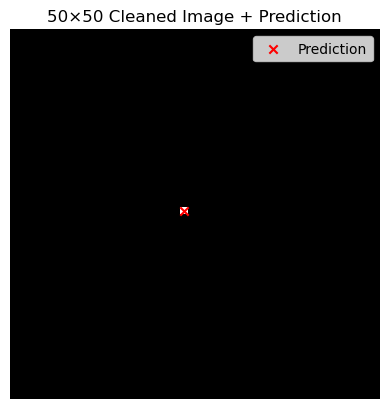

In [ ]:
#Test on Real-time data
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------
# Configuration
# -------------------------
IMAGE_SIZE = 50
MODEL_PATH = "pixel_coordinate_regressor.keras"
IMAGE_PATH = "image.png"

# -------------------------
# Load model
# -------------------------
model = tf.keras.models.load_model(MODEL_PATH)

# -------------------------
# Load & resize image
# -------------------------
image = Image.open(IMAGE_PATH).convert("L")
image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
image = np.array(image, dtype=np.uint8)

# -------------------------
# Signal-preserving cleaning
# -------------------------
cleaned = np.zeros_like(image)
y_sig, x_sig = np.unravel_index(np.argmax(image), image.shape)
cleaned[y_sig, x_sig] = 255

# -------------------------
# Normalize & reshape
# -------------------------
input_tensor = cleaned.astype("float32") / 255.0
input_tensor = input_tensor[np.newaxis, ..., np.newaxis]

# -------------------------
# Predict
# -------------------------
heatmap = model.predict(input_tensor, verbose=0)[0]
hm = heatmap.squeeze()
pred_y, pred_x = np.unravel_index(np.argmax(hm), hm.shape)

# -------------------------
# Output
# -------------------------
print(f"Predicted pixel location → x={pred_x}, y={pred_y}")

# Optional visualization
plt.imshow(cleaned, cmap="gray")
plt.scatter(pred_x, pred_y, c="red", marker="x", label="Prediction")
plt.legend()
plt.title("50×50 Cleaned Image + Prediction")
plt.axis("off")
plt.show()
